# FASTSLAM勉強用ノートブック

In [40]:
import sys
sys.path.append('../scripts/')
from mcl import *
from kf import * # 誤差楕円を描くのに利用

In [41]:
# 推定されたランドマーク
class EstimatedLandmark(Landmark):
    def __init__(self):
        super().__init__(0,0)
        self.cov = None
        
    def draw(self, ax, elems):
        if self.cov is None:
            return
        
        ###推定位置に青い星を描く###
        c = ax.scatter(self.pos[0], self.pos[1], s=100, marker="*", label="landmarks", color="blue")
        elems.append(c)
        elems.append(ax.text(self.pos[0], self.pos[1], "id:" + str(self.id), fontsize=10))
        
        ###誤差楕円を描く###
        e = sigma_ellipse(self.pos, self.cov, 10)
        elems.append(ax.add_patch(e))

In [42]:
# FASTSLAM用のパーティクル、Particleを継承
class MapParticle(Particle):
    def __init__(self, init_pose, weight, landmark_num):
        super().__init__(init_pose, weight)
        self.map = Map()
        
        for i in range(landmark_num):
            self.map.append_landmark(EstimatedLandmark())
            
    def init_landmark_estimation(self, landmark, z, distance_dev_rate, direction_dev):
        x, y, t = self.pose
        ell, phi = z
        mx, my = ell*math.cos(t + phi) + x, ell*math.sin(t + phi) + y
        
        H = np.array([[(mx - x)/math.sqrt(ell), (my - y)/math.sqrt(ell)], 
                      [(y - my)/ell,(mx - x)/ell]])
        
        Q = np.diag(np.array([(distance_dev_rate*ell)**2, direction_dev**2]))
        
        landmark.cov = np.linalg.inv(H.T.dot(np.linalg.inv(Q)).dot(H))
        landmark.pos = np.array([mx, my]).T
        
    def observation_update_landmark(self, landmark, z, distance_dev_rate, direction_dev):  ###fastslam7
        x, y, _ = self.pose
        mx, my =  landmark.pos
        estm_z = IdealCamera.relative_polar_pos(self.pose, landmark.pos)
        estm_ell, _ = estm_z
        if estm_ell < 0.01:
            return
        
        H = np.array([[(mx - x)/math.sqrt(estm_ell), (my - y)/math.sqrt(estm_ell)],  [(y - my)/estm_ell, (mx - x)/estm_ell]])
        Q = np.diag(np.array([(distance_dev_rate*estm_ell)**2, direction_dev**2]))
        K = landmark.cov.dot(H.T).dot( np.linalg.inv(Q + H.dot(landmark.cov).dot(H.T)) )
        
        ###重みの更新###
        Q_z = H.dot(landmark.cov).dot(H.T) + Q
        self.weight *= multivariate_normal(mean=estm_z, cov=Q_z).pdf(z)
        
        ###ランドマークの推定の更新###
        landmark.pos = K.dot(z - estm_z) + landmark.pos
        landmark.cov = (np.eye(2) - K.dot(H)).dot(landmark.cov)
        
    def observation_update(self, observation, distance_dev_rate, direction_dev):
        for d in observation:
            z = d[0]
            landmark = self.map.landmarks[d[1]]
            
            if landmark.cov is None:
                self.init_landmark_estimation(landmark, z, distance_dev_rate, direction_dev)
            else:           #追加
                self.observation_update_landmark(landmark, z, distance_dev_rate, direction_dev)

In [43]:
class FastSlam(Mcl):
    def __init__(self, particle_num, init_pose, landmark_num, motion_noise_stds, distance_dev_rate=0.14, direction_dev=0.05):
        super().__init__(None, init_pose, particle_num, motion_noise_stds, distance_dev_rate, direction_dev)
        
        self.particles = [MapParticle(init_pose, 1.0/particle_num, landmark_num) for i in range(particle_num)]
        self.ml = self.particles[0]
        
    def observation_update(self, observation):
        for p in self.particles:
            p.observation_update(observation, self.distance_dev_rate, self.direction_dev)
        self.set_ml()
        self.resampling()
        
    def draw(self, ax, elems):
        super().draw(ax, elems)
        self.ml.map.draw(ax, elems)

In [44]:
# MclAgentから継承
# FastSlam用のエージェント
# envmap -> landmark_num に代わった理由
## FastSlamAgent は真の地図を受け取らないため、地図は逐次作成する。
## 環境中のランドマークを数えるために、landmark_num がある。
class FastSlamAgent(MclAgent):
    def __init__(self, time_interval, nu, omega, particle_pose, landmark_num, particle_num=100, \
                motion_noise_stds={"nn":0.19, "no":0.001, "on":0.13, "oo":0.2}):
        super().__init__(time_interval, nu, omega, particle_pose, None, particle_num, motion_noise_stds)
        
        # FastSlamオブジェクトを作成（Mclオブジェクトは破棄）
        self.pf = FastSlam(particle_num, particle_pose, landmark_num, motion_noise_stds)
        
#    def decision(self, observation):
#        return super().decision([])

<IPython.core.display.Javascript object>


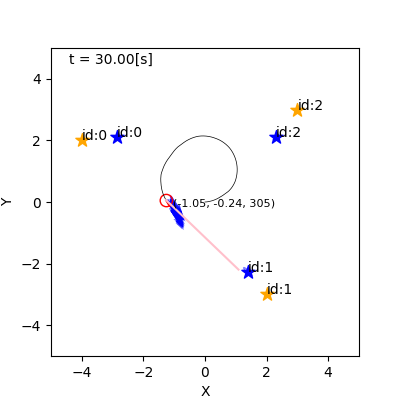

In [45]:
if __name__ == '__main__': 
    # 周期[s]
    time_interval = 0.1
    # 30秒間シミュレート
    world = World(30, time_interval) 

    ###真の地図を作成###
    # 地図をインスタンス化
    m = Map()
    # ランドマークの座標をリストで作成
    landmark_positions = [(-4,2), (2,-3), (3,3)]
    # ランドマークの座標を地図に追加
    for p in landmark_positions:
        m.append_landmark(Landmark(*p))
    
    # 地図情報をワールドへ追加
    world.append(m) 

    ### ロボットを作る ###
    # 旋回運動を行うエージェント
    # circling = MclAgent(time_interval, 0.2, 10.0/180*math.pi, np.array([0, 0, 0]).T, m, particle_num=100)
    # 初期位置
    init_pose = np.array([0,0,0]).T
    # FastSlamAgentを作成
    a = FastSlamAgent(time_interval, 0.2, 10.0/180*math.pi, init_pose, len(m.landmarks))
    # ロボットの変数を作成
    # r = Robot(np.array([0,0,0]).T, sensor=Camera(m), agent=circling, color="red")
    r = Robot(np.array([0,0,0]).T, sensor=Camera(m), agent=a, color="red")
    # ワールドに追加
    world.append(r)

    # ワールドを描画
    world.draw()